In [26]:
import os
from pathlib import Path

os.chdir("/Users/rodrigoestebanantoniopizarroschwerter/projects/resto-ds-rappiflow/dags/analytics/")


import pandas as pd
from utils.query_loader import QueryLoader
from utils.pre_processing import delete_outliers_by_percentiles
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [27]:
template_sources = "/Users/rodrigoestebanantoniopizarroschwerter/projects/resto-ds-rappiflow/dags/analytics/redis_estimation/templates"
queries = QueryLoader(template_sources)

/Users/rodrigoestebanantoniopizarroschwerter/projects/resto-ds-rappiflow/dags/analytics/redis_estimation/templates


In [56]:
countries = ['AR','BR','CL','CO','CR','MX','EC','UY','PE']
countries_dict = {
    'AR':{'mz_min_percentile':0.8,'moment_min_percentile':0.9},
    'BR':{'mz_min_percentile':0.9,'moment_min_percentile':0.9},
    'CL':{'mz_min_percentile':0.9,'moment_min_percentile':0.9},
    'CO':{'mz_min_percentile':0.9,'moment_min_percentile':0.9},
    'CR':{'mz_min_percentile':0.9,'moment_min_percentile':0.9},
    'MX':{'mz_min_percentile':0.9,'moment_min_percentile':0.94},
    'EC':{'mz_min_percentile':0.9,'moment_min_percentile':0.9},
    'UY':{'mz_min_percentile':0.9,'moment_min_percentile':0.9},
    'PE':{'mz_min_percentile':0.9,'moment_min_percentile':0.9},
    }
moment_dict = {
    0:'morning',
    1:'noon',
    2:'afternoon',
    3:'night',
}
dict_constraints = {}
mz_quant = pd.read_csv("redis_estimation/data/mz_logs_distribution_p98_pivot.csv")
for country in countries:
    dict_constraints[country]={}
    for i in range(4):
        moment_quant = pd.read_csv(f"redis_estimation/data/moment_logs_distribution_98_{moment_dict[i]}.csv").fillna(1)
        
        moment_min_dif = np.abs(moment_quant.loc[:,[country]] - countries_dict[country]['moment_min_percentile'])
        moment_min_user_log = moment_quant.iloc[moment_min_dif.idxmin(),:].loc[:,'USER_MOMENT_LOGS'].values[0]
        dict_constraints[country][moment_dict[i]]=moment_min_user_log
    
    mz_min_dif = np.abs(mz_quant.loc[:,[country]] - countries_dict[country]['mz_min_percentile'])
    mz_min_user_log = mz_quant.iloc[mz_min_dif.idxmin(),:].loc[:,'USER_MZ_LOGS'].values[0]
    dict_constraints[country]['mz_min_logs']=mz_min_user_log



In [57]:
countries = ['AR','BR','CL','CO','CR','MX','EC','UY','PE']
countries_dict = dict(zip(countries,np.arange(0,10)))


all_df_combinations = pd.DataFrame(columns=['COUNTRY','N_COMBINATIONS','FALLBACK_MZ_FRANJAS_COMBINATIONS','FALLBACK_MZ_COMBINATIONS'])
for country in countries:
    country_index = countries_dict[country]
    params = {
        "min_mz_logs":dict_constraints[country]['mz_min_logs'],
        "min_morning_logs":dict_constraints[country]['morning'],
        "min_noon_logs":dict_constraints[country]['noon'],
        "min_afternoon_logs":dict_constraints[country]['afternoon'],
        "min_night_logs":dict_constraints[country]['night'],
        "country":country
    }
    df_combinations = queries.execute('prediction_space', params = params, print_statement=False)
    all_df_combinations = all_df_combinations.append(df_combinations)

/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_22922/1106070822.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df_combinations = all_df_combinations.append(df_combinations)
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_22922/1106070822.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df_combinations = all_df_combinations.append(df_combinations)
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_22922/1106070822.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df_combinations = all_df_combinations.append(df_combinations)
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_22922/1106070822.py:17: FutureWarning: The frame.append method is deprecated and will be 

In [58]:
all_df_combinations['TOTAL_COMBINATIONS'] = all_df_combinations['N_COMBINATIONS']+all_df_combinations['FALLBACK_MZ_FRANJAS_COMBINATIONS']+all_df_combinations['FALLBACK_MZ_COMBINATIONS']
all_df_combinations['SIZE_WITH_500_STORES'] = 13.14*all_df_combinations['TOTAL_COMBINATIONS']/1000000
all_df_combinations

COUNTRY N_COMBINATIONS FALLBACK_MZ_FRANJAS_COMBINATIONS  \
0      AR         940763                              374   
0      BR         607440                             3840   
0      CL         449688                              702   
0      CO        2451209                              987   
0      CR          20999                               96   
0      MX        4127839                             2778   
0      EC         141701                              326   
0      UY          15957                               58   
0      PE         764508                              405   

  FALLBACK_MZ_COMBINATIONS TOTAL_COMBINATIONS SIZE_WITH_500_STORES  
0                   212047            1153184            15.152838  
0                   215355             826635            10.861984  
0                   163451             613841             8.065871  
0                   698220            3150416            41.396466  
0                     8937              30032              0.39462  
0                   955395            5086012            66.830198  
0                    46958             188985             2.483263  
0                     6548              22563             0.296478  
0                   237734            1002647            13.174782

In [59]:
all_df_combinations.to_csv('redis_estimation/data/size_estimation.csv',index=False)

In [60]:
df_user_logs_distribution = queries.execute('logs_user_distribution')

Executing Query WITH total_users as (
    SELECT 
        country,
        count(distinct user_id) total_users
    FROM events_home_restaurants.consolidated_prediction_space
    GROUP BY 
        country
)

, logs_per_user as (
    SELECT 
        country,
        user_id,
        sum(total_logs) user_logs
    FROM events_home_restaurants.consolidated_prediction_space
    GROUP BY 
        country,
        user_id
)

SELECT 
    logs_per_user.country,
    logs_per_user.user_logs,
    total_users,
    count(distinct user_id) n_users,
    n_users/total_users as perc_users
FROM logs_per_user
LEFT JOIN total_users on logs_per_user.country = total_users.country
GROUP BY 
    logs_per_user.country,
    user_logs,
    total_users
ORDER BY 
    logs_per_user.country,
    user_logs and params {}


In [61]:
df_user_logs_distribution
df_aux = pd.DataFrame(columns= ['COUNTRY', 'USER_LOGS', 'TOTAL_USERS', 'N_USERS',
       'CUMSUM', 'PERCENTAGE_OF_TOTAL'])
for country in df_user_logs_distribution['COUNTRY'].unique():
    df_country = df_user_logs_distribution.loc[df_user_logs_distribution['COUNTRY']==country,:]
    df_country.loc[:,'CUMSUM'] = df_country.loc[:,'N_USERS'].cumsum()
    df_country.loc[:,'PERCENTAGE_OF_TOTAL'] = df_country.loc[:,'CUMSUM']/df_country.loc[:,'TOTAL_USERS']
    df_aux = df_aux.append(df_country[['COUNTRY', 'USER_LOGS', 'TOTAL_USERS', 'N_USERS',
       'CUMSUM', 'PERCENTAGE_OF_TOTAL']])
df_user_logs_distribution = df_aux

/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_22922/1013564132.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country.loc[:,'CUMSUM'] = df_country.loc[:,'N_USERS'].cumsum()
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_22922/1013564132.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country.loc[:,'PERCENTAGE_OF_TOTAL'] = df_country.loc[:,'CUMSUM']/df_country.loc[:,'TOTAL_USERS']
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_22922/1013564132.py:8: FutureW

In [62]:
df_user_logs_distribution_p98 = df_user_logs_distribution.loc[df_user_logs_distribution['PERCENTAGE_OF_TOTAL']<=0.98,:]

df_user_logs_distribution_p98_pivot = df_user_logs_distribution_p98.pivot(index = ['USER_LOGS'],columns=['COUNTRY'], values = 'PERCENTAGE_OF_TOTAL').reset_index()
df_user_logs_distribution_p98_pivot.to_csv("redis_estimation/data/user_logs_distribution_p98_pivot.csv",index=False)

/opt/anaconda3/envs/analytics/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


<AxesSubplot:xlabel='USER_LOGS', ylabel='PERCENTAGE_OF_TOTAL'>

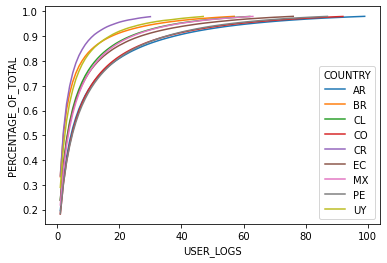

In [63]:
sns.lineplot(data=df_user_logs_distribution_p98, x = 'USER_LOGS' , y= 'PERCENTAGE_OF_TOTAL',hue='COUNTRY')

In [64]:
df_mz_logs_distribution = queries.execute(
    "mz_logs_distribution"
)

Executing Query WITH logs_user_mz as (
    SELECT 
        country,
        microzone_id,
        user_id,
        sum(total_logs) user_mz_logs
    FROM events_home_restaurants.consolidated_prediction_space
    GROUP BY 
        country,
        microzone_id,
        user_id
)

, combinations_user_mz as (
    SELECT 
        country,
        user_mz_logs,
        count(*) mz_user_combinations
    FROM logs_user_mz
    GROUP BY 
        country,
        user_mz_logs
)

, country_user_mz_combinations as (
    SELECT
        country,
        sum(mz_user_combinations) country_combinations
    FROM combinations_user_mz
    GROUP BY 
        country
)
SELECT 
    combinations_user_mz.country,
    combinations_user_mz.user_mz_logs,
    combinations_user_mz.mz_user_combinations,
    country_user_mz_combinations.country_combinations,
    mz_user_combinations/country_combinations as perc_users
FROM combinations_user_mz
LEFT JOIN country_user_mz_combinations on combinations_user_mz.country = coun

In [65]:
df_mz_logs_distribution
df_aux = pd.DataFrame(columns= ['COUNTRY', 'USER_MZ_LOGS', 'MZ_USER_COMBINATIONS', 'COUNTRY_COMBINATIONS',
       'CUMSUM', 'PERCENTAGE_OF_TOTAL'])
for country in df_mz_logs_distribution['COUNTRY'].unique():
    df_country = df_mz_logs_distribution.loc[df_mz_logs_distribution['COUNTRY']==country,:]
    df_country['CUMSUM'] = df_country['MZ_USER_COMBINATIONS'].cumsum()
    df_country['PERCENTAGE_OF_TOTAL'] = df_country['CUMSUM']/df_country['COUNTRY_COMBINATIONS']
    df_aux = df_aux.append(df_country[['COUNTRY', 'USER_MZ_LOGS', 'MZ_USER_COMBINATIONS', 'COUNTRY_COMBINATIONS',
       'CUMSUM', 'PERCENTAGE_OF_TOTAL']])
df_mz_logs_distribution = df_aux
df_mz_logs_distribution_p98 = df_mz_logs_distribution.loc[df_mz_logs_distribution['PERCENTAGE_OF_TOTAL']<=0.98,:]

df_mz_logs_distribution_p98_pivot = df_mz_logs_distribution_p98.pivot(index = ['USER_MZ_LOGS'],columns=['COUNTRY'], values = 'PERCENTAGE_OF_TOTAL').reset_index()
df_mz_logs_distribution_p98_pivot.to_csv("redis_estimation/data/mz_logs_distribution_p98_pivot.csv",index=False)

/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_22922/239833364.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['CUMSUM'] = df_country['MZ_USER_COMBINATIONS'].cumsum()
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_22922/239833364.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['PERCENTAGE_OF_TOTAL'] = df_country['CUMSUM']/df_country['COUNTRY_COMBINATIONS']
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_22922/239833364.py:8: FutureWarning: The

In [28]:
df_moment_logs_distribution = queries.execute(
    "moments_orders_logs"
)

Executing Query with logs_per_user as (
    SELECT 
        country,
        SUBSTRING(user_id,4) AS user_id,
        moment,
        sum(daily_logs) user_moment_logs
    FROM events_home_restaurants.daily_prediction_space_user_microzone_moment
    WHERE 1=1
        --AND country = ''
        AND created_at BETWEEN DATEADD('day',-89,CURRENT_DATE) AND DATEADD('day',-1,CURRENT_DATE)
    GROUP BY 
        country,
        user_id,
        moment
)

, orders_per_user as (
    SELECT 
        global_orders.country,
        global_orders.application_user_id::varchar as user_id,
        CASE 
        WHEN TIME(global_orders.created_at) BETWEEN '05:00:00' AND '11:00:00' THEN 'morning'
        WHEN TIME(global_orders.created_at) BETWEEN '11:00:01' AND '15:00:00' THEN 'noon'
        WHEN TIME(global_orders.created_at) BETWEEN '15:00:01' AND '18:00:00' THEN 'afternoon'
        ELSE 'night' END MOMENT,
        COUNT(DISTINCT global_orders.order_id) user_moment_orders
    FROM global_finances.globa

In [32]:
df_moment_logs_distribution_grouped = df_moment_logs_distribution.groupby(['COUNTRY','MOMENT','USER_MOMENT_LOGS']).sum()[['USER_MOMENT_ORDERS']].reset_index()
for moment in df_moment_logs_distribution_grouped.MOMENT.unique():
    df_moment = df_moment_logs_distribution_grouped.loc[df_moment_logs_distribution_grouped.MOMENT == moment, :]
    cols = list(df_moment_logs_distribution_grouped.columns)
    cols.append('PERCENTAGE_OF_TOTAL')
    df_moments_cumsum = pd.DataFrame(columns = cols)
    for country in df_moment.COUNTRY.unique():
        df_moment_country = df_moment.loc[df_moment['COUNTRY']==country,:]
        df_moment_country_total = df_moment_country.groupby(['COUNTRY']).sum()[['USER_MOMENT_ORDERS']].reset_index()
        df_moment_country_total.columns = ['COUNTRY','TOTAL_COUNTRY_ORDERS']
        df_moment_country = df_moment_country.merge(df_moment_country_total, on = 'COUNTRY')
        df_moment_country['CUMSUM'] = df_moment_country['USER_MOMENT_ORDERS'].cumsum()
        df_moment_country['PERCENTAGE_OF_TOTAL'] = df_moment_country['CUMSUM'] / df_moment_country['TOTAL_COUNTRY_ORDERS']
        df_moments_cumsum = df_moments_cumsum.append(df_moment_country)
    df_moments_cumsum_p98 = df_moments_cumsum.loc[df_moments_cumsum['PERCENTAGE_OF_TOTAL']<=0.98,:]   
    df_moments_cumsum_pivot = df_moments_cumsum_p98.pivot(index='USER_MOMENT_LOGS',columns = ['COUNTRY'],values='PERCENTAGE_OF_TOTAL').reset_index()
    df_moments_cumsum_pivot.to_csv(f"./redis_estimation/data/moment_logs_distribution_98_{moment}.csv",index=False)

/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_98296/2160915538.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_moments_cumsum = df_moments_cumsum.append(df_moment_country)
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_98296/2160915538.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_moments_cumsum = df_moments_cumsum.append(df_moment_country)
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_98296/2160915538.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_moments_cumsum = df_moments_cumsum.append(df_moment_country)
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_98296/2160915538.py:14: FutureWarning: The frame.append method is deprecated and will be remove

## Analisis users CVR alto con pocas sesiones

In [68]:
params = {'country' : 'CL'}
df_cvr = queries.execute('high_cvr_low_sessions_users', params =params )

Executing Query with logs_per_user as (
    SELECT 
        country,
        SUBSTRING(user_id,4) AS user_id,
        sum(daily_logs) user_logs
    FROM events_home_restaurants.daily_prediction_space_user_microzone_moment
    WHERE 1=1
        --AND country = 'CL'
        AND created_at BETWEEN DATEADD('day',-89,CURRENT_DATE) AND DATEADD('day',-1,CURRENT_DATE)
    GROUP BY 
        country,
        user_id
)

, orders_per_user as (
    SELECT 
        global_orders.country,
        global_orders.application_user_id::varchar as user_id,
        COUNT(DISTINCT global_orders.order_id) user_orders
    FROM global_finances.global_orders
    LEFT JOIN events_home_restaurants.source_by_order ON global_orders.country = source_by_order.country
                                                    AND global_orders.order_id = source_by_order.order_id
    WHERE 1=1
        --AND global_orders.country = 'CL'
        AND vertical_group = 'RESTAURANTS'
        AND order_state NOT IN (
                

In [69]:
df_cvr['CVR'] = df_cvr['CVR'].apply(float)
df_cvr_qa = df_cvr.loc[df_cvr.CVR <= 1,:]
print(len(df_cvr_qa)/len(df_cvr))

0.9992322986328186


In [70]:
df_cvr_qa = delete_outliers_by_percentiles(df_cvr_qa,['USER_LOGS','USER_ORDERS'],0.99)

In [71]:
df_cvr_qa.describe()

USER_ORDERS     USER_LOGS           CVR
count  5.845805e+06  5.845805e+06  5.845805e+06
mean   4.184736e+00  2.243781e+01  2.612307e-01
std    5.582915e+00  2.580133e+01  2.169668e-01
min    1.000000e+00  1.000000e+00  5.650000e-03
25%    1.000000e+00  6.000000e+00  1.126760e-01
50%    2.000000e+00  1.300000e+01  2.000000e-01
75%    5.000000e+00  2.900000e+01  3.333330e-01
max    3.600000e+01  1.770000e+02  1.000000e+00

<AxesSubplot:xlabel='USER_LOGS', ylabel='CVR'>

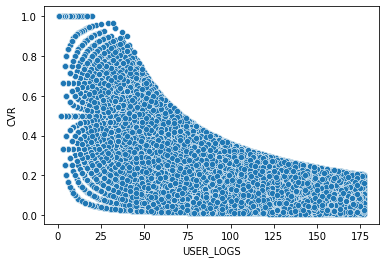

In [72]:
sns.scatterplot(data = df_cvr_qa , x = 'USER_LOGS', y='CVR')

In [73]:
df_user_logs_vs_mean_cvr = df_cvr_qa.groupby(['COUNTRY','USER_LOGS']).mean().reset_index()
df_user_logs_vs_mean_cvr = df_user_logs_vs_mean_cvr[df_user_logs_vs_mean_cvr['USER_LOGS']>1]
df_user_logs_vs_mean_cvr = df_user_logs_vs_mean_cvr.loc[df_user_logs_vs_mean_cvr['COUNTRY'] != 'UY',:]
df_user_logs_vs_mean_cvr = df_user_logs_vs_mean_cvr.loc[df_user_logs_vs_mean_cvr['COUNTRY'] != 'CR',:]
df_user_logs_vs_mean_cvr

COUNTRY  USER_LOGS  USER_ORDERS       CVR
1         AR        2.0     1.085896  0.542948
2         AR        3.0     1.212702  0.404234
3         AR        4.0     1.288492  0.322123
4         AR        5.0     1.431836  0.286367
5         AR        6.0     1.511643  0.251941
...      ...        ...          ...       ...
1354      PE      173.0    18.297872  0.105768
1355      PE      174.0    19.882353  0.114266
1356      PE      175.0    18.870968  0.107834
1357      PE      176.0    20.519481  0.116588
1358      PE      177.0    19.372549  0.109449

[1232 rows x 4 columns]

In [6]:
params = {'country' : 'AR'}

df_logs_mz = queries.execute('mz_orders_logs', params =params )
df_logs_mz = delete_outliers_by_percentiles(df_logs_mz,['USER_MZ_LOGS','USER_MZ_SESSIONS'],0.99)

Executing Query with logs_per_user as (
    SELECT 
        country,
        SUBSTRING(user_id,4) AS user_id,
        microzone_id,
        sum(daily_logs) user_mz_logs
    FROM events_home_restaurants.daily_prediction_space_user_microzone_moment
    WHERE 1=1
        --AND country = 'AR'
        AND created_at BETWEEN DATEADD('day',-89,CURRENT_DATE) AND DATEADD('day',-1,CURRENT_DATE)
    GROUP BY 
        country,
        user_id,
        microzone_id
)

, orders_per_user as (
    SELECT 
        global_orders.country,
        global_orders.application_user_id::varchar as user_id,
        global_orders.microzone_id,
        COUNT(DISTINCT global_orders.order_id) user_mz_orders
    FROM global_finances.global_orders
    LEFT JOIN events_home_restaurants.source_by_order ON global_orders.country = source_by_order.country
                                                    AND global_orders.order_id = source_by_order.order_id    
                                                    and glo

In [7]:
df_logs_mz=df_logs_mz.sort_values(['COUNTRY','USER_ID','MICROZONE_ID'])

KeyboardInterrupt: 

In [8]:
df_logs_mz.groupby(['COUNTRY','USER_MZ_LOGS']).sum()

MICROZONE_ID  USER_MZ_ORDERS
COUNTRY USER_MZ_LOGS                              
AR      1                 51174445           62040
        2                 30145532           64407
        3                 19453442           61685
        4                 13746044           59031
        5                  9924987           55476
...                            ...             ...
UY      72                       8              25
        73                       2               0
        74                      17              39
        75                      29              46
        76                      18              11

[684 rows x 2 columns]

/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_98296/3876169247.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['PERCENTAGE_OF_TOTAL'] = df_country['PERC_TOTAL_ORDENES'].cumsum()
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_98296/3876169247.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux = df_aux.append(df_country[['COUNTRY', 'USER_MZ_LOGS', 'MICROZONE_ID', 'USER_MZ_ORDERS','TOTAL_MZ_ORDERS','PERC_TOTAL_ORDENES','PERCENTAGE_OF_TOTAL']])
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_98296/3876169247.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

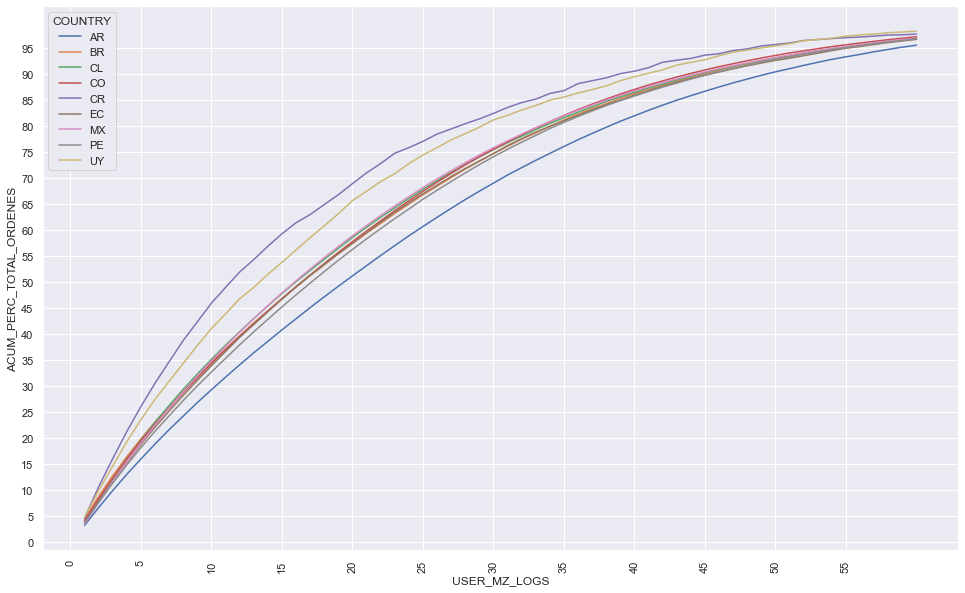

In [22]:
df_logs_mz_trafico = df_logs_mz.groupby(['COUNTRY','USER_MZ_LOGS']).sum().reset_index()
df_logs_mz_trafico = df_logs_mz_trafico.loc[df_logs_mz_trafico['USER_MZ_LOGS']<=60,:]
df_logs_mz_trafico_pais = df_logs_mz.groupby(['COUNTRY']).sum()[['USER_MZ_SESSIONS']].reset_index()
df_logs_mz_trafico_pais.columns = ['COUNTRY','TOTAL_MZ_SESSIONS']
df_logs_mz_trafico = df_logs_mz_trafico.merge(df_logs_mz_trafico_pais, on = 'COUNTRY')
df_logs_mz_trafico['PERC_TOTAL_ORDENES'] = df_logs_mz_trafico['USER_MZ_SESSIONS']/df_logs_mz_trafico['TOTAL_MZ_SESSIONS']

df_aux = pd.DataFrame(columns=list(df_logs_mz_trafico.columns))
for country in df_logs_mz_trafico.COUNTRY.unique():
    df_country = df_logs_mz_trafico.loc[df_logs_mz_trafico['COUNTRY']==country,:]
    df_country['PERCENTAGE_OF_TOTAL'] = df_country['PERC_TOTAL_ORDENES'].cumsum()
    df_aux = df_aux.append(df_country[['COUNTRY', 'USER_MZ_LOGS', 'MICROZONE_ID', 'USER_MZ_ORDERS','TOTAL_MZ_ORDERS','PERC_TOTAL_ORDENES','PERCENTAGE_OF_TOTAL']])


df_aux['ACUM_PERC_TOTAL_ORDENES'] = df_aux['PERCENTAGE_OF_TOTAL']*100
sns.set()
plt.figure(figsize=(16.4,10))
ax = sns.lineplot(data = df_aux , x = 'USER_MZ_LOGS', y= 'ACUM_PERC_TOTAL_ORDENES', hue = 'COUNTRY')

plt.xticks(rotation = 90)
ax.set_yticks(np.arange(0,100,5))
ax.set_xticks(np.arange(0,60,5))




In [24]:
df_aux.pivot(index=['USER_MZ_LOGS'],columns=['COUNTRY'],values=['PERCENTAGE_OF_TOTAL']).to_csv("redis_estimation/data/mz_logs_order_distribution_pivot.csv")

/opt/anaconda3/envs/analytics/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [11]:
plt.figure(figsize=(16.2,10))
sns.lineplot(data = df_user_logs_vs_mean_cvr, x = 'USER_LOGS' , y = 'CVR', hue='COUNTRY')
plt.ylabel("Mean CVR")
plt.xlabel("User Logs")

NameError: name 'df_user_logs_vs_mean_cvr' is not defined

<Figure size 1166.4x720 with 0 Axes>

Text(0.5, 1.0, "['MX', 'CO'] - Dispersion of CVR in User Logs")

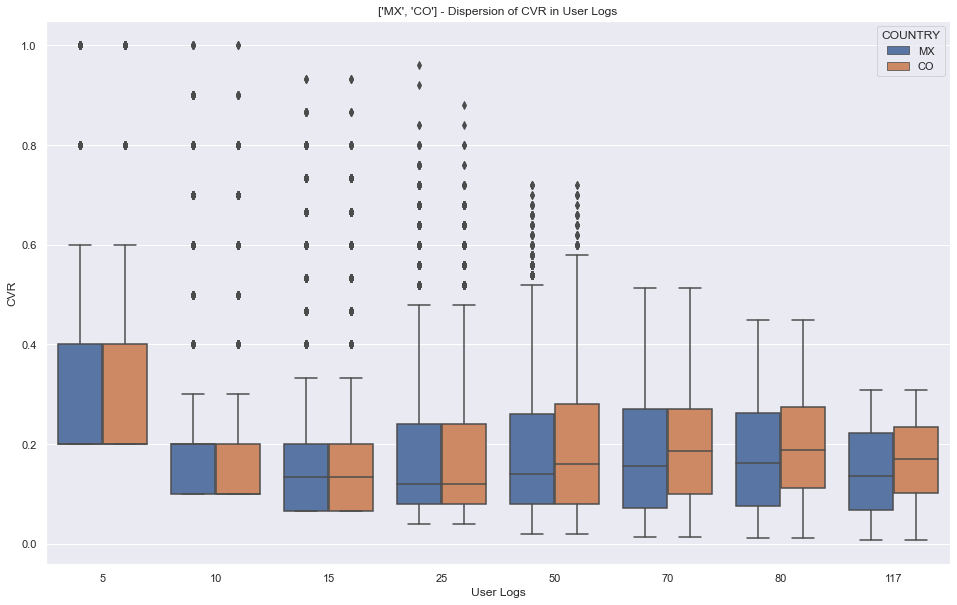

In [75]:
values = [5,6,7,8,9,10,15,25,50,100,150,175]
values = [5,10,15,25,50,70,80,117]

countries = ['MX','CO']
df_cvr_qa['USER_LOGS']=df_cvr_qa['USER_LOGS'].apply(int)

df_boxplot = df_cvr_qa.loc[df_cvr_qa['COUNTRY'].isin(countries),:]
df_boxplot = df_boxplot.loc[df_boxplot['USER_LOGS'].isin(values),:]
sns.set()
plt.figure(figsize=(16.2,10))
sns.boxplot(data =df_boxplot, x = 'USER_LOGS' , y = 'CVR', hue = 'COUNTRY')
plt.ylabel("CVR")
plt.xlabel("User Logs")
plt.title(f"{countries} - Dispersion of CVR in User Logs")

In [76]:
mean_cvr = df_boxplot.groupby(['COUNTRY','USER_LOGS']).mean()[['CVR']]
mean_cvr.columns = ['MEAN_CVR']
mean_cvr.reset_index(inplace=True)

median_cvr = df_boxplot.groupby(['COUNTRY','USER_LOGS']).median()[['CVR']]
median_cvr.columns = ['MEDIAN_CVR']
median_cvr.reset_index(inplace=True)

std_cvr = df_boxplot.groupby(['COUNTRY','USER_LOGS']).std()[['CVR']]
std_cvr.columns = ['STD_CVR']
std_cvr.reset_index(inplace=True)

cvr_descriptors = mean_cvr.merge(median_cvr, on = ['COUNTRY','USER_LOGS'])

cvr_descriptors = cvr_descriptors.merge(std_cvr, on = ['COUNTRY','USER_LOGS'])
cvr_descriptors.to_csv("redis_estimation/data/cvr_descriptors.csv",index=False)


cvr_descriptors

COUNTRY  USER_LOGS  MEAN_CVR  MEDIAN_CVR   STD_CVR
0       CO          5  0.277037    0.200000  0.133376
1       CO         10  0.189814    0.100000  0.118700
2       CO         15  0.172560    0.133333  0.121144
3       CO         25  0.168772    0.120000  0.121936
4       CO         50  0.190984    0.160000  0.127472
5       CO         70  0.196209    0.185714  0.114446
6       CO         80  0.199041    0.187500  0.107557
7       CO        117  0.168199    0.170940  0.078992
8       MX          5  0.273990    0.200000  0.132324
9       MX         10  0.194265    0.200000  0.124173
10      MX         15  0.174316    0.133333  0.122677
11      MX         25  0.169265    0.120000  0.126086
12      MX         50  0.178283    0.140000  0.131314
13      MX         70  0.182889    0.157143  0.125599
14      MX         80  0.176984    0.162500  0.113438
15      MX        117  0.147112    0.136752  0.085768

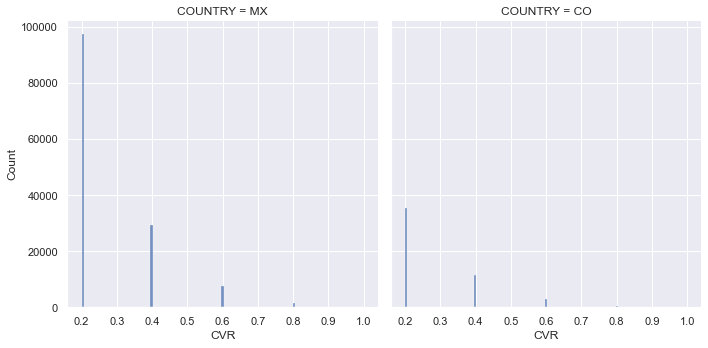

In [77]:

df_boxplot_dist = df_boxplot.loc[df_boxplot['USER_LOGS']==5,:]
sns.displot(data=df_boxplot_dist,x='CVR',col='COUNTRY')

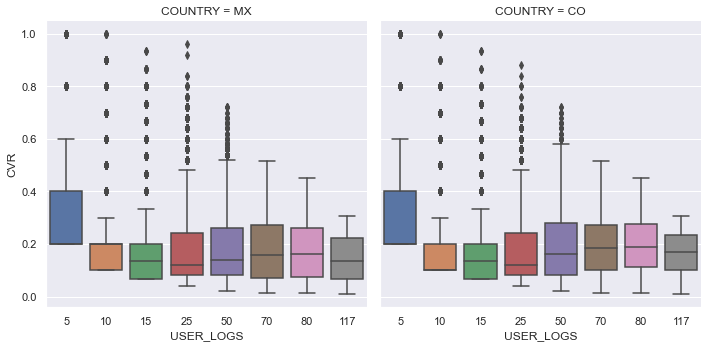

In [78]:

df_catplot = df_boxplot

sns.set(rc={'figure.figsize':(16.2,10)})

sns.catplot(
    data=df_catplot, x="USER_LOGS", y="CVR", col="COUNTRY",
    kind="box"
)
# , bw=.25, cut=0, split=True,



In [79]:
df_cvr_count = df_cvr.groupby(['COUNTRY','USER_LOGS']).count()[['USER_ID']].reset_index()

df_cvr_count_country = df_cvr_count.groupby(['COUNTRY']).sum()[['USER_ID']].reset_index()
df_cvr_count_country.columns = ['COUNTRY','TOTAL_USERS']

df_cvr_count = df_cvr_count.merge(df_cvr_count_country, on = 'COUNTRY')


df_cvr_count['PERC_TOTAL'] = df_cvr_count['USER_ID']/ df_cvr_count['TOTAL_USERS']
df_cvr_count = df_cvr_count.loc[df_cvr_count['COUNTRY'].isin(countries),:]

df_aux = pd.DataFrame(columns= ['COUNTRY', 'USER_LOGS','USER_ID', 'TOTAL_USERS', 'PERC_TOTAL',
       'CUMSUM', 'PERC_TOTAL_ACUM'])
for country in df_cvr_count['COUNTRY'].unique():
    df_country = df_cvr_count.loc[df_cvr_count['COUNTRY']==country,:]
    df_country.loc[:,'CUMSUM'] = df_country.loc[:,'USER_ID'].cumsum()
    df_country.loc[:,'PERC_TOTAL_ACUM'] = df_country.loc[:,'CUMSUM']/df_country.loc[:,'TOTAL_USERS']
    df_aux = df_aux.append(df_country[['COUNTRY', 'USER_LOGS','USER_ID', 'TOTAL_USERS', 'PERC_TOTAL',
       'CUMSUM', 'PERC_TOTAL_ACUM']])
    
df_cvr_count = df_aux


#df_cvr_count = df_cvr_count.loc[df_cvr_count['PERC_TOTAL_ACUM']<=0.95,:]
df_cvr_count['USER_LOGS'] = df_cvr_count['USER_LOGS'].apply(int)
df_cvr_count


/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_22922/1632331100.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country.loc[:,'CUMSUM'] = df_country.loc[:,'USER_ID'].cumsum()
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_22922/1632331100.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country.loc[:,'PERC_TOTAL_ACUM'] = df_country.loc[:,'CUMSUM']/df_country.loc[:,'TOTAL_USERS']
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_22922/1632331100.py:18: FutureWa

COUNTRY  USER_LOGS USER_ID TOTAL_USERS PERC_TOTAL   CUMSUM  \
1650      CO          1   38838     1405866   0.027626    38838   
1651      CO          2   57032     1405866   0.040567    95870   
1652      CO          3   50252     1405866   0.035745   146122   
1653      CO          4   58572     1405866   0.041663   204694   
1654      CO          5   50527     1405866    0.03594   255221   
...      ...        ...     ...         ...        ...      ...   
3550      MX       1627       1     2752858        0.0  2752854   
3551      MX       1662       1     2752858        0.0  2752855   
3552      MX       2106       1     2752858        0.0  2752856   
3553      MX       2246       1     2752858        0.0  2752857   
3554      MX       2968       1     2752858        0.0  2752858   

     PERC_TOTAL_ACUM  
1650        0.027626  
1651        0.068193  
1652        0.103937  
1653          0.1456  
1654         0.18154  
...              ...  
3550        0.999999  
3551        0.999999  
3552        0.999999  
3553             1.0  
3554             1.0  

[1433 rows x 7 columns]

/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_22922/623659843.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cvr_count_barplot.loc[:,'PERC_TOTAL_ACUM'] = df_cvr_count_barplot['PERC_TOTAL_ACUM'].apply(lambda x: round(x,2))


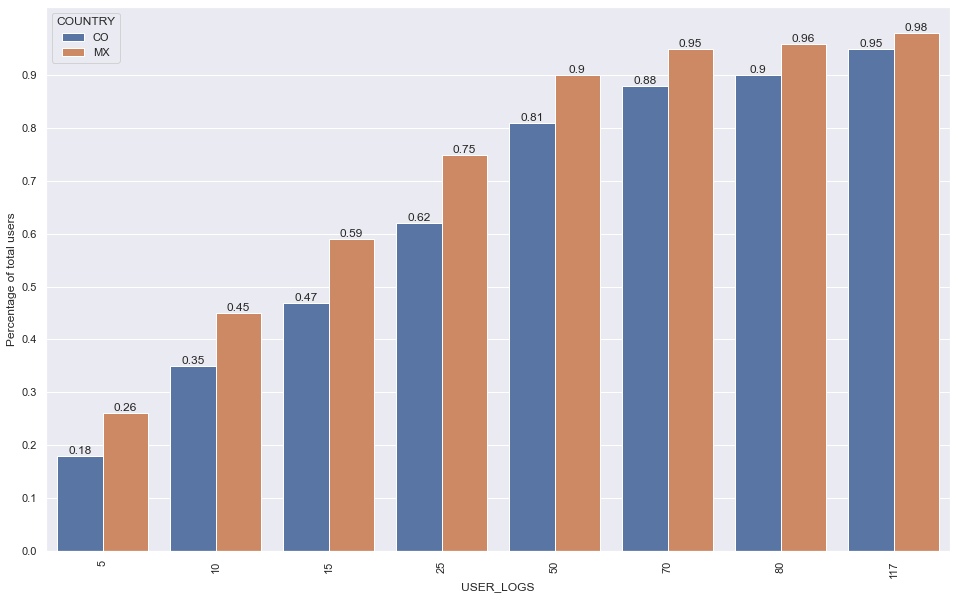

In [80]:
values = [5,10,15,25,50,70,80,117]

df_cvr_count_barplot = df_cvr_count.loc[df_cvr_count['USER_LOGS'].isin(values),:]
df_cvr_count_barplot.loc[:,'PERC_TOTAL_ACUM'] = df_cvr_count_barplot['PERC_TOTAL_ACUM'].apply(lambda x: round(x,2))
ax = sns.barplot(data = df_cvr_count_barplot, x = 'USER_LOGS' , y = 'PERC_TOTAL_ACUM', hue = 'COUNTRY')
plt.xticks(rotation = 90)
ax.set_yticks(np.arange(0,1,0.1))

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.ylabel("Percentage of total users")

df_cvr_count_barplot.to_csv("redis_estimation/data/cvr_count.csv",index=False)

Text(0, 0.5, 'Percentage of total users')

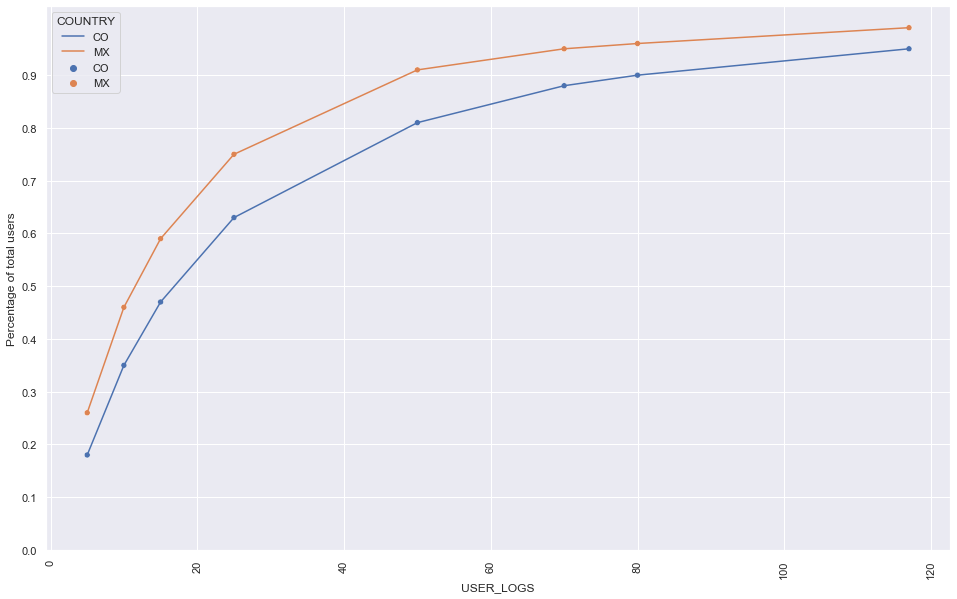

In [327]:
ax = sns.lineplot(data = df_cvr_count_barplot, x = 'USER_LOGS' , y = 'PERC_TOTAL_ACUM', hue = 'COUNTRY')
sns.scatterplot(data = df_cvr_count_barplot, x = 'USER_LOGS' , y = 'PERC_TOTAL_ACUM', hue = 'COUNTRY')
plt.xticks(rotation = 90)
ax.set_yticks(np.arange(0,1,0.1))


plt.ylabel("Percentage of total users")

In [53]:
df_cvr_qa 

NameError: name 'df_cvr_qa' is not defined

### Analisis de frecuencia de logs entre compras

In [368]:
params = {'country': 'CO'}
df_user_logs = queries.execute('logs_between_orders',params = params)

Executing Query WITH between_orders as (
    SELECT 
        o.country,
        o.created_at,
        'CO_' || o.application_user_id as user_id,
        o.order_id,
        LEAD(o.created_at) OVER(PARTITION BY o.application_user_id ORDER BY o.created_at) next_order_datetime
    FROM global_finances.global_orders o
    LEFT JOIN events_home_restaurants.source_by_order ON o.country = source_by_order.country
                                                    AND o.order_id = source_by_order.order_id
    WHERE 1 = 1
        AND o.country = 'CO'
        AND o.created_at >= DATEADD('day',-90,CURRENT_DATE)
        AND o.store_type = 'restaurant'
        AND o.order_state NOT IN (
                'canceled_for_payment_error'
                , 'canceled_by_fraud'
                , 'canceled_by_split_error'
            )
        AND source_by_order.source NOT IN ('GLOBAL_SEARCH','others') 
        AND source_by_order.source IS NOT NULL

)


, user_logs as (

   SELECT 
        o.country,
      

<AxesSubplot:xlabel='USER_ORDERS', ylabel='AVG_LOGS_BETWEEN_ORDERS'>

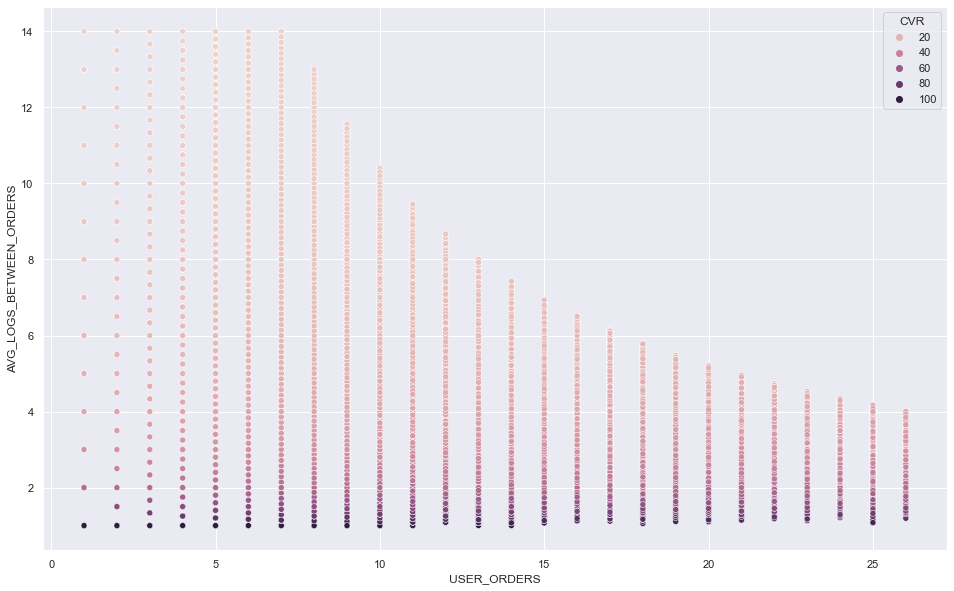

In [279]:
df_user_logs.loc[:,'USER_LOGS'] = df_user_logs.loc[:,'USER_LOGS'].apply(int)
df_user_logs.loc[:,'AVG_LOGS_BETWEEN_ORDERS'] = df_user_logs.loc[:,'AVG_LOGS_BETWEEN_ORDERS'].apply(float)
df_user_logs.loc[:,'CVR'] = 100*df_user_logs.loc[:,'USER_ORDERS']/df_user_logs.loc[:,'USER_LOGS']
df_user_logs.loc[:,'CVR'] = df_user_logs.loc[:,'CVR'].apply(lambda x: round(x,2))
df_user_logs_qa = delete_outliers_by_percentiles(df_user_logs,['USER_LOGS','AVG_LOGS_BETWEEN_ORDERS','USER_ORDERS'],0.98)
sns.scatterplot(data=df_user_logs_qa, x = 'USER_ORDERS' , y = 'AVG_LOGS_BETWEEN_ORDERS', hue = 'CVR')

In [278]:
df_user_logs_qa

COUNTRY        USER_ID  USER_ORDERS  USER_LOGS  \
0           CO   CO_177260376            1          3   
1           CO    CO_15729072            9         16   
3           CO    CO_11651010           28         83   
4           CO   CO_161849844           15         51   
5           CO    CO_17743323           10         23   
...        ...            ...          ...        ...   
690449      CO   CO_108916763            1          1   
690450      CO   CO_124436262            1          1   
690451      CO  CO_1310761727            1          2   
690452      CO   CO_156892934            1          1   
690453      CO  CO_1815593337            1          2   

        AVG_LOGS_BETWEEN_ORDERS     CVR  
0                      3.000000   33.33  
1                      1.777778   56.25  
3                      2.964286   33.73  
4                      3.400000   29.41  
5                      2.300000   43.48  
...                         ...     ...  
690449                 1.000000  100.00  
690450                 1.000000  100.00  
690451                 2.000000   50.00  
690452                 1.000000  100.00  
690453                 2.000000   50.00  

[664735 rows x 6 columns]

In [363]:
co_user_logs_between_orders = pd.read_csv("redis_estimation/data/logs_between_orders_CO.csv", sep = ",")
mx_user_logs_between_orders = pd.read_csv("redis_estimation/data/logs_between_orders_MX.csv", sep = ",")

co_user_logs_between_orders_qa = delete_outliers_by_percentiles(co_user_logs_between_orders,['USER_LOGS','AVG_LOGS_BETWEEN_ORDERS','USER_ORDERS'],0.98)
mx_user_logs_between_orders_qa = delete_outliers_by_percentiles(mx_user_logs_between_orders,['USER_LOGS','AVG_LOGS_BETWEEN_ORDERS','USER_ORDERS'],0.98)


In [364]:
co_user_logs_descriptor = co_user_logs_between_orders_qa.loc[co_user_logs_between_orders_qa['USER_LOGS'].isin(values),:]
mx_user_logs_descriptor = mx_user_logs_between_orders_qa.loc[mx_user_logs_between_orders_qa['USER_LOGS'].isin(values),:]


In [365]:
user_logs_descriptor = co_user_logs_descriptor.append(mx_user_logs_descriptor)

/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_8672/1306732824.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_logs_descriptor = co_user_logs_descriptor.append(mx_user_logs_descriptor)


<AxesSubplot:xlabel='USER_ORDERS', ylabel='AVG_LOGS_BETWEEN_ORDERS'>

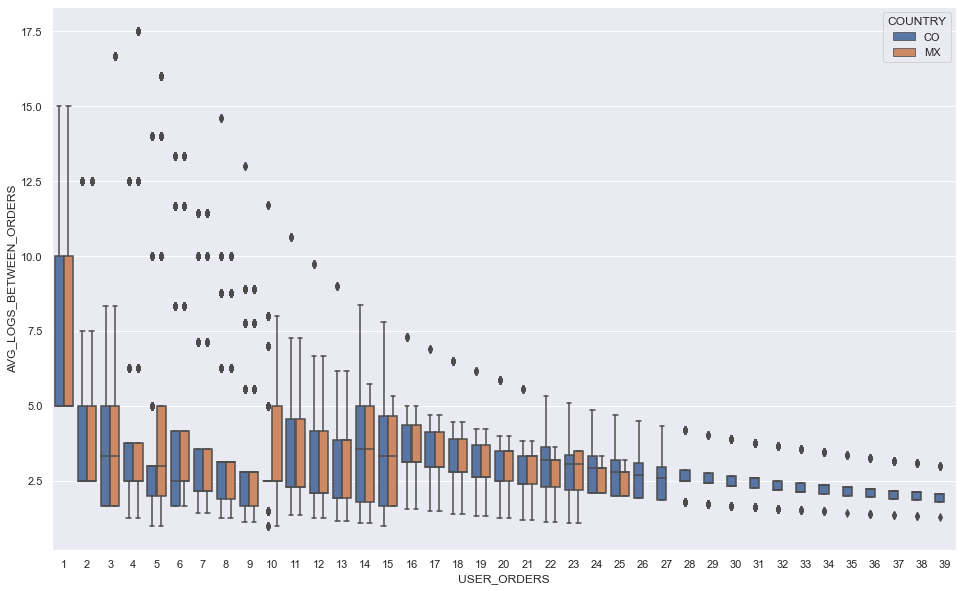

In [366]:
sns.boxplot(data= user_logs_descriptor, x='USER_ORDERS',y = 'AVG_LOGS_BETWEEN_ORDERS', hue = 'COUNTRY')

In [34]:
# Sessions pero logs

df_logs_sessions_mz = queries.execute('sessions_per_user', params =params )


Executing Query  with logs_per_user as (
    SELECT 
        country,
        SUBSTRING(user_id,4) AS user_id,
        microzone_id,
        sum(daily_logs) user_mz_logs
    FROM events_home_restaurants.daily_prediction_space_user_microzone_moment
    WHERE 1=1
        --AND country = 'AR'
        AND created_at BETWEEN DATEADD('day',-89,CURRENT_DATE) AND DATEADD('day',-1,CURRENT_DATE)
    GROUP BY 
        country,
        user_id,
        microzone_id
)
, sessions as (
    select 
        SUBSTRING(s.user_id,4) user_id
        , s.microzone_id
        , s.country
        , COUNT(DISTINCT s.session_id) user_mz_sessions
    from events_home_restaurants.sessions_calculated_information s
    where s.hr_session = 1
    and s.created_at_tz::date BETWEEN DATEADD('day',-89,CURRENT_DATE) AND DATEADD('day',-1,CURRENT_DATE)
    and s.microzone_id is not null
    --AND country = 'AR'
    GROUP BY 
        s.country,
        s.user_id,
        s.microzone_id
)


SELECT
    l.country,
    l.user_i

KeyError: 'USER_MZ_SESSIONS'

In [37]:
df_logs_sessions_mz = delete_outliers_by_percentiles(df_logs_sessions_mz,['USER_MZ_LOGS','USER_MZ_SESSIONS'],0.99)
df_logs_mz_trafico = df_logs_sessions_mz.groupby(['COUNTRY','USER_MZ_LOGS']).sum().reset_index()
#df_logs_mz_trafico = df_logs_mz_trafico.loc[df_logs_mz_trafico['USER_MZ_LOGS']<=60,:]
df_logs_mz_trafico_pais = df_logs_mz_trafico.groupby(['COUNTRY']).sum()[['USER_MZ_SESSIONS']].reset_index()
df_logs_mz_trafico_pais.columns = ['COUNTRY','TOTAL_MZ_SESSIONS']
df_logs_mz_trafico = df_logs_mz_trafico.merge(df_logs_mz_trafico_pais, on = 'COUNTRY')
df_logs_mz_trafico['PERC_TOTAL_SESSIONS'] = df_logs_mz_trafico['USER_MZ_SESSIONS']/df_logs_mz_trafico['TOTAL_MZ_SESSIONS']




KeyError: 'PERC_TOTAL_ORDENES'

/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_98296/2052903021.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['PERCENTAGE_OF_TOTAL'] = df_country['PERC_TOTAL_SESSIONS'].cumsum()
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_98296/2052903021.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux = df_aux.append(df_country[['COUNTRY', 'USER_MZ_LOGS', 'MICROZONE_ID', 'USER_MZ_SESSIONS','TOTAL_MZ_SESSIONS','PERC_TOTAL_SESSIONS','PERCENTAGE_OF_TOTAL']])
/var/folders/sp/y74nffbn57g3h99vn71k511r0000gp/T/ipykernel_98296/2052903021.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

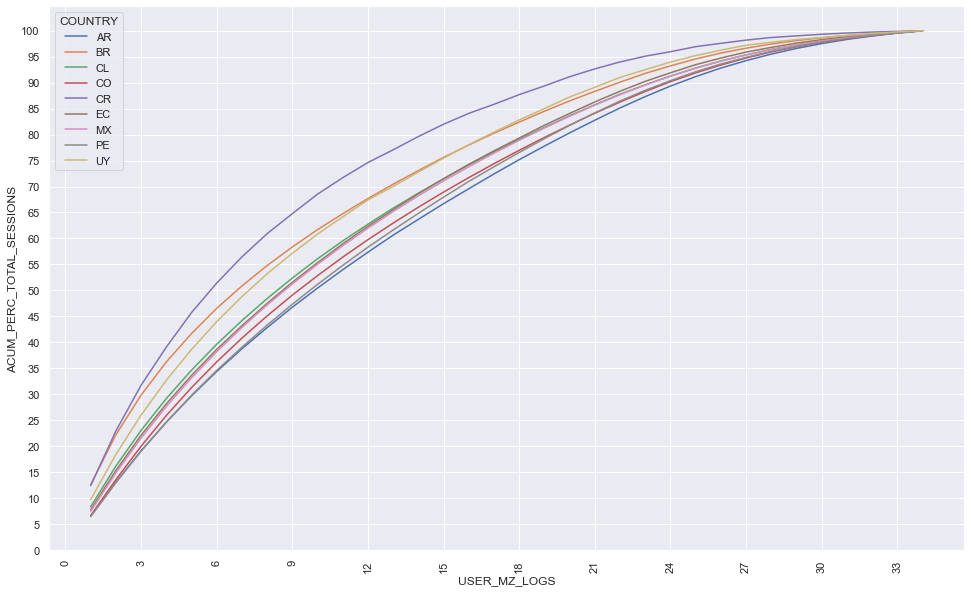

In [40]:
df_aux = pd.DataFrame(columns=list(df_logs_mz_trafico.columns))
for country in df_logs_mz_trafico.COUNTRY.unique():
    df_country = df_logs_mz_trafico.loc[df_logs_mz_trafico['COUNTRY']==country,:]
    df_country['PERCENTAGE_OF_TOTAL'] = df_country['PERC_TOTAL_SESSIONS'].cumsum()
    df_aux = df_aux.append(df_country[['COUNTRY', 'USER_MZ_LOGS', 'MICROZONE_ID', 'USER_MZ_SESSIONS','TOTAL_MZ_SESSIONS','PERC_TOTAL_SESSIONS','PERCENTAGE_OF_TOTAL']])


df_aux['ACUM_PERC_TOTAL_SESSIONS'] = df_aux['PERCENTAGE_OF_TOTAL']*100
sns.set()
plt.figure(figsize=(16.4,10))
ax = sns.lineplot(data = df_aux , x = 'USER_MZ_LOGS', y= 'ACUM_PERC_TOTAL_SESSIONS', hue = 'COUNTRY')

plt.xticks(rotation = 90)
ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,35,3))

In [41]:
df_aux.pivot(index=['USER_MZ_LOGS'],columns=['COUNTRY'],values=['PERCENTAGE_OF_TOTAL']).to_csv("redis_estimation/data/mz_logs_sessions_distribution_pivot.csv")

/opt/anaconda3/envs/analytics/lib/python3.10/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
